In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [2]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [3]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2


In [4]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [5]:
# Analyze each day separately or combine them
# data = day_data[DAY_0]
data = combined_data
time = data["CROISSANTS"]["timestamp"]

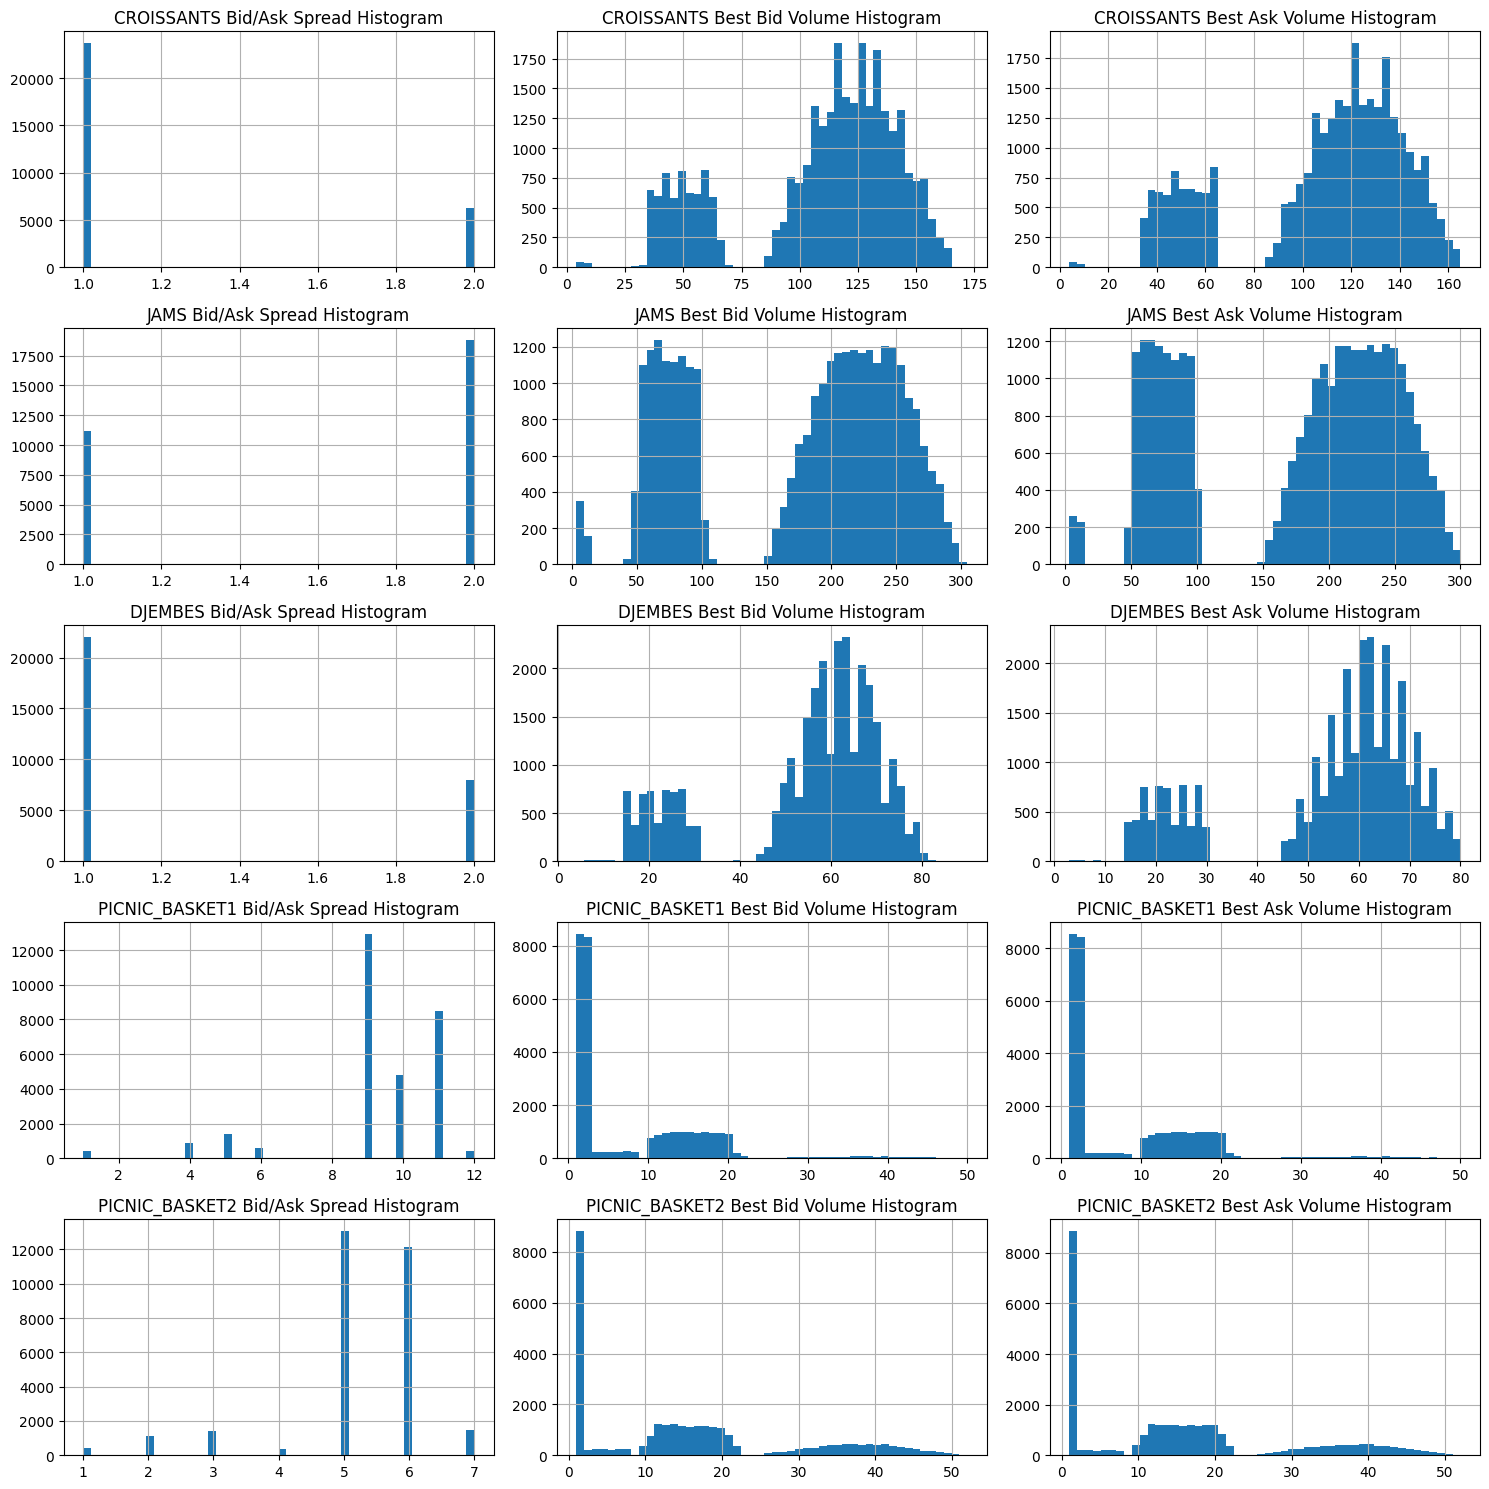

In [6]:
fig, axs = plt.subplots(len(products), 3, figsize=(15, 15))
for i, product in enumerate(products):
    for j in range(3):
        if j == 0:
            axs[i, j].hist(data[product]["spread"], bins=50)
            axs[i, j].set_title(f"{product} Bid/Ask Spread Histogram")
            axs[i, j].grid()
        elif j == 1:
            axs[i, j].hist(data[product]["bid_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Bid Volume Histogram")
            axs[i, j].grid()
        else:
            axs[i, j].hist(data[product]["ask_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Ask Volume Histogram")
            axs[i, j].grid()

plt.tight_layout()
# plt.savefig("figures/new_products_price_histograms.png")

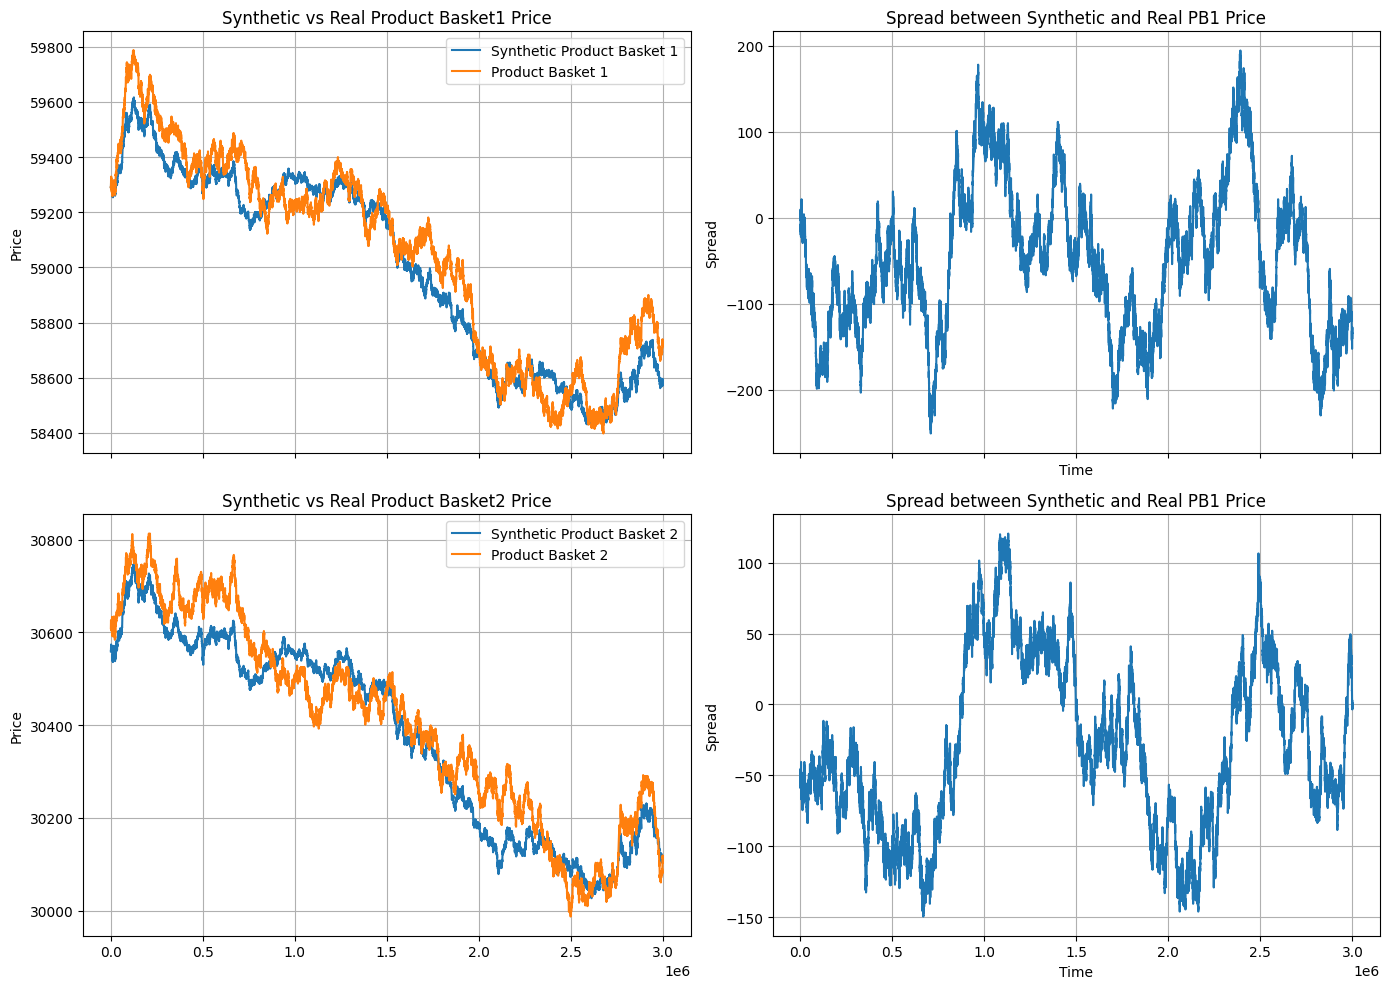

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

for i in range(2):
    axs[i, 0].plot(time, data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"], label=f"Synthetic Product Basket {i+1}")
    axs[i, 0].plot(time, data[f"PICNIC_BASKET{i+1}"]["mid_price"], label=f"Product Basket {i+1}")
    axs[i, 0].grid()
    axs[i, 0].legend()
    axs[i, 0].set_ylabel("Price")
    axs[i, 0].set_title(f"Synthetic vs Real Product Basket{i+1} Price")

    spread = data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"] - data[f"PICNIC_BASKET{i+1}"]["mid_price"]
    axs[i, 1].plot(time, spread, label="Spread")
    axs[i, 1].grid()
    axs[i, 1].set_ylabel("Spread")
    axs[i, 1].set_xlabel("Time")
    axs[i, 1].set_title("Spread between Synthetic and Real PB1 Price")

plt.tight_layout()
# plt.savefig("figures/synthetic_vs_real.png")

In [12]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller

def interpret_adf(result):
    p_val = result[1]

    print(f"p-value: {p_val:.4f}")
    
    # Interpretation
    if p_val < 0.05:
        print("Result: Series is STATIONARY ")
       
    else:
        print("Result: Series is NON-STATIONARY")

print("Correlation between synthetic and real Product Basket 1")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET1"]["mid_price"], data["PICNIC_BASKET1"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB1 returns:")
syn_pb1_returns = np.diff(data["SYN_PICNIC_BASKET1"]["mid_price"]) / data["SYN_PICNIC_BASKET1"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb1_returns))
pb1_returns = np.diff(data["PICNIC_BASKET1"]["mid_price"]) / data["PICNIC_BASKET1"]["mid_price"][:-1]
print("PB1 returns:")
interpret_adf(adfuller(pb1_returns))

print()

print("Correlation between synthetic and real Product Basket 2")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET2"]["mid_price"], data["PICNIC_BASKET2"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB2 returns:")
syn_pb2_returns = np.diff(data["SYN_PICNIC_BASKET2"]["mid_price"]) / data["SYN_PICNIC_BASKET2"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb2_returns))
pb2_returns = np.diff(data["PICNIC_BASKET2"]["mid_price"]) / data["PICNIC_BASKET2"]["mid_price"][:-1]
print("PB2 returns:")
interpret_adf(adfuller(pb2_returns))

Correlation between synthetic and real Product Basket 1
Pearson correlation coefficient: 0.9722889725256896
P-value: 0.0
Synthetic PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 

Correlation between synthetic and real Product Basket 2
Pearson correlation coefficient: 0.9604927615024059
P-value: 0.0
Synthetic PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 


In [13]:
from statsmodels.tsa.stattools import coint
# Calculate cointegration
score, p_value, _ = coint(syn_pb1_returns, pb1_returns)
print("Product Basket 1 Syn/Real Cointegration")
print(f"Cointegration score: {score}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The two series are cointegrated.")
else:
    print("The two series are not cointegrated.")

print()

score, p_value, _ = coint(syn_pb2_returns, pb2_returns)
print("Product Basket 2 Syn/Real Cointegration")
print(f"Cointegration score: {score}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The two series are cointegrated.")
else:
    print("The two series are not cointegrated.")

Product Basket 1 Syn/Real Cointegration
Cointegration score: -108.01923673242048
P-value: 0.0
The two series are cointegrated.

Product Basket 2 Syn/Real Cointegration
Cointegration score: -109.77936099949692
P-value: 0.0
The two series are cointegrated.


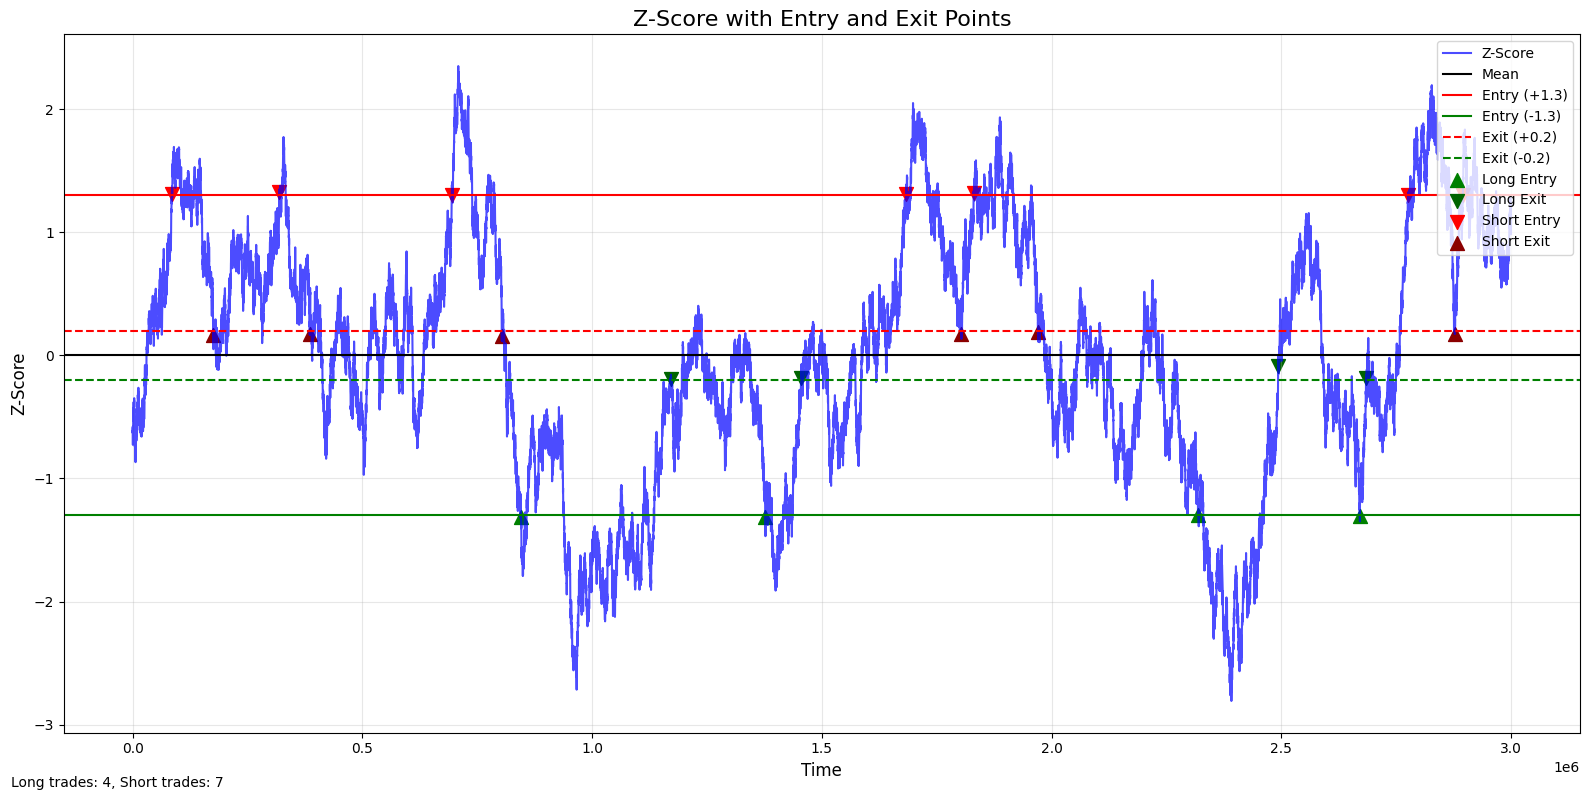

Number of long entries: 4
Number of short entries: 7
Total trades: 11


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate z-score of the spread (if not already done)
mean_spread = np.mean(spread)
std_spread = np.std(spread)
z_score = (spread - mean_spread) / std_spread

# Define entry and exit thresholds
entry_threshold = 1.3
exit_threshold = 0.2

# Initialize position tracking
position = 0  # 0 = no position, 1 = long spread, -1 = short spread
positions = np.zeros(len(z_score))

# Track entry and exit points
long_entries = []
long_exits = []
short_entries = []
short_exits = []

# Loop through the z-score to identify trade points
for i in range(1, len(z_score)):
    # Check for exit signals first
    if position == 1 and z_score[i] >= -exit_threshold:  # Exit long position
        long_exits.append(i)
        position = 0
    elif position == -1 and z_score[i] <= exit_threshold:  # Exit short position
        short_exits.append(i)
        position = 0
    
    # Check for entry signals
    elif position == 0 and z_score[i] <= -entry_threshold:  # Enter long position
        long_entries.append(i)
        position = 1
    elif position == 0 and z_score[i] >= entry_threshold:  # Enter short position
        short_entries.append(i)
        position = -1
    
    positions[i] = position

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(t, z_score, label='Z-Score', color='blue', alpha=0.7)

# Add horizontal lines for thresholds
plt.axhline(y=0, color='black', linestyle='-', label='Mean')
plt.axhline(y=entry_threshold, color='red', linestyle='-', label=f'Entry (+{entry_threshold})')
plt.axhline(y=-entry_threshold, color='green', linestyle='-', label=f'Entry (-{entry_threshold})')
plt.axhline(y=exit_threshold, color='red', linestyle='--', label=f'Exit (+{exit_threshold})')
plt.axhline(y=-exit_threshold, color='green', linestyle='--', label=f'Exit (-{exit_threshold})')

# Plot entry and exit points
plt.scatter([t[i] for i in long_entries], [z_score[i] for i in long_entries], 
           color='green', s=100, marker='^', label='Long Entry')
plt.scatter([t[i] for i in long_exits], [z_score[i] for i in long_exits], 
           color='darkgreen', s=100, marker='v', label='Long Exit')
plt.scatter([t[i] for i in short_entries], [z_score[i] for i in short_entries], 
           color='red', s=100, marker='v', label='Short Entry')
plt.scatter([t[i] for i in short_exits], [z_score[i] for i in short_exits], 
           color='darkred', s=100, marker='^', label='Short Exit')

# Add labels and legend
plt.title('Z-Score with Entry and Exit Points', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Add trade counts
plt.figtext(0.01, 0.01, 
            f"Long trades: {len(long_entries)}, Short trades: {len(short_entries)}", 
            ha='left', fontsize=10)

plt.tight_layout()
plt.show()

# Print trade summary
print(f"Number of long entries: {len(long_entries)}")
print(f"Number of short entries: {len(short_entries)}")
print(f"Total trades: {len(long_entries) + len(short_entries)}")